In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"    

/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_18/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# Dilema entre el sesgo y la varianza

## Tabla de Contenidos

1. <a href="#section_intro">Introducción</a>

2. <a href="#sesgo_varianza">Sesgo y varianza</a>
- 2.1 <a href="#sv_simple">Un modelo simple</a>
- 2.2 <a href="#sv_cuadratico">Un modelo cuadrático</a>
- 2.3 <a href="#sv_complejo">Un modelo más complejo</a>
- 2.4 <a href="#sv_new_data">Prediciendo datos nuevos: *underfitting* y *overfitting*</a>

3. <a href="#ttcv">*Train-test split* y *cross-validation*</a>
- 3.1 <a href="#ttcv_comparando">Comparando el ajuste y la generalización de distintos modelos</a>
  - 3.1.1 <a href="#ttcv_uno">Modelo de grado 1</a>
  - 3.1.2 <a href="#ttcv_dos">Modelo de grado 2</a>
  - 3.1.3 <a href="#ttcv_diez">Modelo de grado 10</a>
  - 3.1.4 <a href="#ttcv_cv">*Cross-validation*</a>

4. <a href="#section_resumen">En resumen</a>

---

<a id="section_intro"></a>
##  Introducción

Ya hemos visto dos ejemplos de *machine learning* supervisado: entrenamos un modelo de regresión lineal para estimar las ventas de un producto a partir del gasto destinado a publicitarlo en TV y también construimos un modelo de clasificación para detectar *defaults* de tarjetas de crédito. Hicimos hincapié en que el foco está puesto en la predicción, sobre todo de datos nuevos, de ahí la importancia de hacer una separación de los **conjuntos de entrenamiento y testeo**.

En un escenario ideal, un modelo puede predecir correctamente los datos que reservamos para testear, obteniendo una métrica de *performance* considerablemente alta. En esta situación, podemos darnos por satisfechos con el proceso de entrenamiento y proceder con la disponibilización del modelo para su uso productivo. **Ahora bien, en caso de que los resultados no sean los que esperamos... ¿cómo lo resolvemos?** Veremos que hay distintos factores que pueden hacer que un modelo no tenga una buena capacidad predictiva:

- Podemos estar usando un **modelo demasiado simple**, que no logra aprender lo suficiente de los datos de entrenamiento y, como consecuencia, tampoco logra predicir muy bien los datos de testeo.
- Podemos estar trabajando con un **modelo excesivamente complejo**, que se amolda tanto a los datos que conoce que no logra generalizar a datos desconocidos.
- Si el dataset es chico, podemos **no contar con suficientes muestras** para lograr un entrenamiento idóneo.
- Tal vez la cantidad de observaciones es suficiente para un buen ajuste a los datos, pero **las *features* no aportan suficiente información** o su representación no es la adecuada.

En esta oportunidad, nos concentraremos en los primeros dos puntos. Vamos a comparar el desempeño de un modelo en *train* con su desempeño en *test* para tener una mayor noción acerca de sus capacidades de ajuste a los datos de entrenamiento y de generalización a datos nuevos, respectivamente. Esto nos servirá para introducir un aspecto crucial de *machine learning*: **el dilema entre el sesgo y la varianza**. Cuando hablamos de **sesgo**, estamos pensando en un escenario como el del primer punto, en el que tenemos un **modelo muy simple que subajusta a los datos y por eso no tiene un buen desempeño en ninguno de los conjuntos de datos**. En cambio, cuando hablamos de **varianza**, nos encontramos en una situación como la del segundo punto, en que nuestro **modelo tiene una excesiva flexibilidad que lo lleva a sobreajustar a los datos de entrenamiento pero que no le permite predecir bien los datos de testeo**. Veremos que ambos escenarios traen aparejados inconvenientes que buscaremos evitar, tratando siempre de hallar un **ajuste óptimo** del modelo. Dado que los problemas responden a motivos diferententes, veremos que las estrategias de solución dependerán del tipo de escenario en el que nos encontremos.

En esta notebook trabajaremos sobre algunos conceptos fundamentales de *machine learning* supervisado que son constantes independientemente del modelo que estemos entrenando: **sesgo y varianza, subajuste y sobreajuste y validación cruzada**. Veremos qué problemas surgen al trabajar con modelos demasiado simples o demasiado complejos y propondremos una metodología para encontrar la complejidad óptima de un modelo.

<a id="sesgo_varianza"></a>
## Sesgo y varianza

Para ilustrar los conceptos de sesgo y varianza, trabajaremos sobre datos aleatorios que responden a cierta función generadora conocida y ajustaremos a ellos modelos de distinta complejidad. **Por el momento, cuando hablemos de la complejidad de un modelo, estaremos pensando en la cantidad de *features* que incluye**: un modelo con una única *feature* es un modelo más simple que otro con diez *features*, por ejemplo. Veremos que modelos simples que no ajustan lo suficiente a los datos tendrán asociado un alto sesgo, mientras que los modelos muy complejos que sobre ajustan a los datos tendrán asociada una alta varianza.

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Empezamos generando pares $(x, y)$ aleatorios a partir de una función cuadrática que incorpora cierta aleatoriedad y los visualizamos:

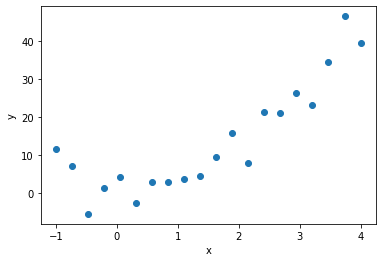

In [3]:
n = 20
np.random.seed(10)
a = 3
b = -1
c = 1
x = np.linspace(-1, 4, n)
y = a*x**2 + b*x + c + np.random.randn(n)*5
plt.scatter(x, y)
plt.xlabel('x');
plt.ylabel('y');

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/haciendo_foco.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;"><label><b>Los datos son generados por una función cuadrática con la forma<br> $y=ax^2+bx+c+\epsilon$, donde $\epsilon$ es una perturbación aleatoria.</b></label></div>
</div>

<a id="sv_simple"></a>
### Un modelo simple

Comenzaremos ajustando un modelo de regresión lineal simple a estos puntos, que serán nuestros datos de entrenamiento. Seguiremos paso a paso el flujo de trabajo de Scikit-Learn que ya hemos presentado antes:

In [4]:
# Importamos la clase LinearRegression 
from sklearn.linear_model import LinearRegression

In [5]:
# Instanciamos el modelo
lr = LinearRegression()

In [6]:
# Ajustamos el modelo a los datos
lr.fit(x.reshape(-1,1), y);

Hasta acá, creamos un objeto almacenado en la variable 'lr' que pertenece a la clase `LinearRegression()` que, luego de ejecutar `lr.fit()`, encontró los parámetros del modelo lineal que mejor se ajustan a los datos de entrenamiento. ¿Cuáles son estos parámetros?

In [7]:
# Imprimimos la ordenada al origen
lr.intercept_

1.9962587274425552

In [8]:
# Imprimimos la pendiente
lr.coef_

array([7.83682227])

Con el modelo ya entrenado, podemos hacer predicciones. Digamos que tenemos un nuevo dato cuyo valor de $x$ es $x_n=2.5$. Entonces, la predicción del modelo consiste en calcular $ \hat{y_n} = \hat{\beta_0} + \hat{\beta_1} x_{n} $, donde $\hat{\beta_0}$ es la ordenada al origen y $\hat{\beta_1}$, la pendiente de la recta:

In [9]:
x_n = 2.5
y_estimado = lr.intercept_ + lr.coef_[0] * x_n
print(y_estimado)

21.588314400718286


También podemos usar el método `.predict()` del modelo para hacer el mismo cálculo:

In [10]:
lr.predict(np.array(x_n, ndmin=2))

array([21.5883144])

Y lo podemos aplicar sobre todo el array:

In [11]:
y_pred = lr.predict(x.reshape(-1,1))
y_pred

array([-5.84056354, -3.77824189, -1.71592024,  0.34640141,  2.40872306,
        4.47104471,  6.53336636,  8.59568801, 10.65800966, 12.72033131,
       14.78265296, 16.84497461, 18.90729626, 20.96961791, 23.03193956,
       25.09426121, 27.15658286, 29.21890451, 31.28122615, 33.3435478 ])

Veamos cómo se ajusta la recta encontrada a los datos de entrenamiento:

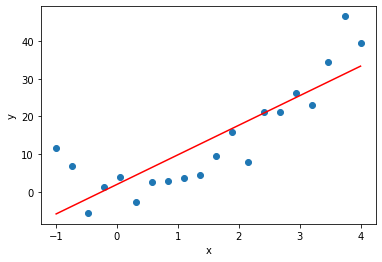

In [12]:
plt.plot(x, x*lr.coef_[0]+lr.intercept_,'r')
plt.scatter(x, y)
plt.xlabel('x');
plt.ylabel('y');

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿Cómo se ve este ajuste del modelo a los datos? Considerando la naturaleza cuadrática de la función que generó las observaciones, ¿creés que esta recta explica bien la relación entre $x$ e $y$?</b></label></div>
</div>

Evaluemos la *performance* de nuestro modelo lineal simple a partir de las métricas que ya conocemos, el **error absoluto medio**, el **error cuadrático medio** y el $R^2$:

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print('La media del error absoluto es', mae.round(2))
print('La media del error cuadrático es', mse.round(2))
print('La raíz del error cuadrático medio', rmse.round(2))
print('El R2 es', r2.round(2))

La media del error absoluto es 5.91
La media del error cuadrático es 56.38
La raíz del error cuadrático medio 7.51
El R2 es 0.71


Nuestro modelo simple logra explicar un 71% de la varianza total de $y$. No está mal, pero considerando la naturaleza del problema, es probable que podamos encontrar un modelo mejor.

<a id="sv_cuadratico"></a>
### Un modelo cuadrático

Dado que los datos fueron generados a partir de una función que tiene un componente cuadrático, veamos ahora qué ocurre cuando incorporamos una *feature* que es el cuadrado de $x$:

In [14]:
# Generamos un DataFrame con los datos
df = pd.DataFrame({'x':x, 'y':y})
df.head()

,x,y
0,-1.000000,11.657933
1,-0.736842,6.942046
2,-0.473684,-5.580187
3,-0.210526,1.301571
4,0.052632,4.062359


Ahora creemos una nueva columna que sea $x^2$:

In [15]:
df['x2'] = df['x']**2
df = df[['x', 'x2', 'y']]
df.head()

,x,x2,y
0,-1.000000,1.000000,11.657933
1,-0.736842,0.542936,6.942046
2,-0.473684,0.224377,-5.580187
3,-0.210526,0.044321,1.301571
4,0.052632,0.002770,4.062359


Ya que tenemos un *feature* nueva, podemos entrenar otro modelo de regresión lineal que incorpore esta información.

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/haciendo_foco.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;"><label><b>Dado que ahora tenemos más de una <i>feature</i> o variable explicativa, en este caso se trata de un modelo de regresión lineal múltiple en lugar de simple. Ahora, la predicción para cualquier dato $x_n$ viene dada por $ \hat{y_n} = \hat{\beta_0} + \hat{\beta_1} x_{n} +  \hat{\beta_2} x_{n}^2 $.</b></label></div>
</div>

In [16]:
lr2 = LinearRegression()
lr2.fit(df[['x', 'x2']], df['y']);

¿Cuáles son los parámetros aprendidos por el modelo?

In [17]:
lr2.intercept_

1.8360708832860002

In [18]:
lr2.coef_

array([-1.29388485,  3.04356904])

Notemos que ahora el atributo `coef_` es un array con dos elementos, que se correponden con $\hat{\beta_1}$ y $\hat{\beta_2}$, respectivamente.

Con este otro modelo ya entrenado, podemos hacer nuevas predicciones:

In [19]:
y_pred_2 = lr2.predict(df[['x', 'x2']])

Visualicemos la nueva curva de ajuste a los datos:

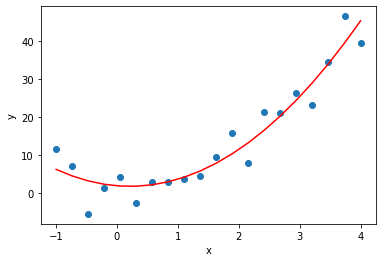

In [20]:
plt.plot(x, y_pred_2, 'r')
plt.scatter(x,y)
plt.xlabel('x');
plt.ylabel('y');

¡Se ve mucho mejor! Parecería que esta nueva variable explicativa, $x^2$, le otorga una mayor flexibilidad al modelo lineal que le permite aprender mejor qué relación hay entre las *features* y el *target*. Veamos si las métricas de evaluación respaldan esta intuición visual:

In [21]:
mae_2 = mean_absolute_error(y, y_pred_2)
mse_2 = mean_squared_error(y, y_pred_2)
rmse_2 = np.sqrt(mse)
r2_2 = r2_score(y, y_pred_2)

print('La media del error absoluto es', mae_2.round(2))
print('La media del error cuadrático es', mse_2.round(2))
print('La raíz del error cuadrático medio', rmse_2.round(2))
print('El R2 es', r2_2.round(2))

La media del error absoluto es 3.3
La media del error cuadrático es 17.38
La raíz del error cuadrático medio 7.51
El R2 es 0.91


¡Excelente! Vemos que todas las métricas mejoraron considerablemente agregando tan sólo una nueva *feature*. Pero entonces... ¿por qué detenernos en un $R^2$ del 0.91? Si seguimos agregando *features*, tal vez podamos darle todavía más flexibilidad al modelo y continuar mejorando las métricas.

<a id="sv_complejo"></a>
### Un modelo más complejo

Seamos ambiciosos e incorporemos más *features* polinómicas hasta el grado 10:

In [22]:
for i in range(3,11):
    df['x{}'.format(i)] = df['x']**i # El método .format() nos permite darle un formato variable a un string
                                     # En este caso, el contenido de {} varía en cada iteración de acuerdo al valor de i

df = df[['x'] + ['x{}'.format(i) for i in range(2,11)] + ['y']]
df.head()

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.000000,1.000000,-1.000000,1.000000,-1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,11.657933
1,-0.736842,0.542936,-0.400058,0.294780,-2.172062e-01,1.600467e-01,-1.179291e-01,8.689514e-02,-6.402800e-02,4.717852e-02,6.942046
2,-0.473684,0.224377,-0.106284,0.050345,-2.384759e-02,1.129623e-02,-5.350845e-03,2.534611e-03,-1.200605e-03,5.687077e-04,-5.580187
3,-0.210526,0.044321,-0.009331,0.001964,-4.135537e-04,8.706395e-05,-1.832925e-05,3.858790e-06,-8.123768e-07,1.710267e-07,1.301571
4,0.052632,0.002770,0.000146,0.000008,4.038611e-07,2.125585e-08,1.118729e-09,5.888046e-11,3.098972e-12,1.631038e-13,4.062359


Ahora que tenemos el dataset con las nuevas *features* polinómicas, volvamos a entrenar un nuevo modelo y calcular las métricas de evaluación:

In [23]:
lr10 = LinearRegression()
lr10.fit(df.drop('y', axis=1), df['y']);

Veamos los parámetros del modelo:

In [24]:
lr10.intercept_

1.6706426381290438

In [25]:
lr10.coef_

array([  9.24683306, -23.97070594, -16.28597777,  67.37999961,
       -29.630109  , -26.31222648,  29.88411171, -11.54187732,
         2.03916228,  -0.13873434])

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿A qué se debe que observemos un array de 10 coeficientes?</b></label></div>
</div>

Ya estamos listos para hacer predicciones y evaluar la *performance* del modelo:

In [26]:
y_pred_10 = lr10.predict(df.drop(columns=['y']))

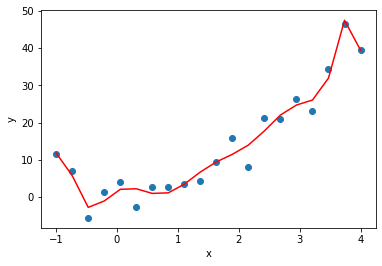

In [27]:
plt.plot(x, y_pred_10, 'r')
plt.scatter(x,y)
plt.xlabel('x');
plt.ylabel('y');

In [28]:
mae_10 = mean_absolute_error(y, y_pred_10)
mse_10 = mean_squared_error(y, y_pred_10)
rmse_10 = np.sqrt(mse)
r2_10 = r2_score(y, y_pred_10)

print('La media del error absoluto es', mae_10.round(2))
print('La media del error cuadrático es', mse_10.round(2))
print('La raíz del error cuadrático medio', rmse_10.round(2))
print('El R2 es', r2_10.round(2))

La media del error absoluto es 2.12
La media del error cuadrático es 7.06
La raíz del error cuadrático medio 7.51
El R2 es 0.96


¡Seguimos mejorando! Tenemos un $R^2$ altísimo y los errores son cada vez más bajos.

Para poder comparar visualmente los modelos explorados, generamos un gráfico que representa los distintos ajustes obtenidos de acuerdo al grado del polinomio de cada uno de los modelos:

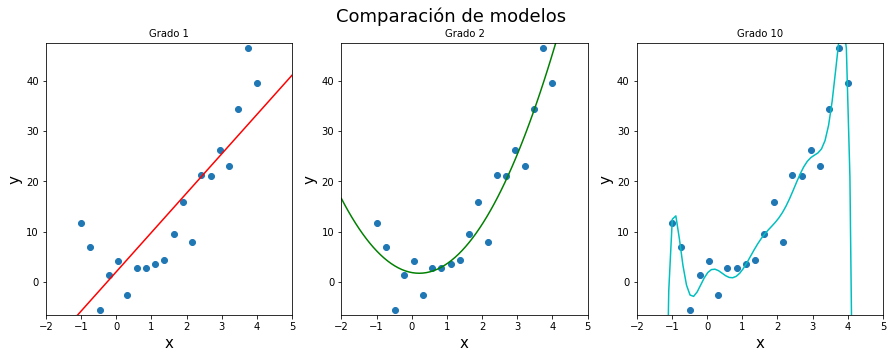

In [29]:
# Generamos un eje para graficar las curvas
ejex = np.linspace(-2,8, 100)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Comparación de modelos', fontsize=18)

# Ploteamos los datos
for axes in ax:
    axes.scatter(x, y)
    axes.set_xlim([x.min()-1, x.max()+1])
    axes.set_ylim([y.min()-1, y.max()+1])
    axes.set_xlabel('x', fontsize=15)
    axes.set_ylabel('y', fontsize=15)
    
# Modelo de grado 1
curva1 = lr.predict(ejex.reshape(-1,1))
ax[0].plot(ejex, curva1, 'r')
ax[0].set_title('Grado 1', fontsize=10)

# Modelo de grado 2
curva2 = lr2.predict(np.vander(ejex, 3, increasing=True)[:,1:])
ax[1].plot(ejex, curva2, 'g')
ax[1].set_title('Grado 2', fontsize=10)

# Modelo de grado 10
curva10 = lr10.predict(np.vander(ejex, 11, increasing=True)[:,1:])
ax[2].plot(ejex, curva10, 'c')
ax[2].set_title('Grado 10', fontsize=10);

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿Qué observamos en estos gráficos? ¿Cuál de los tres modelos parecería describir mejor la naturaleza de los datos?</b></label></div>
</div>

<a id="sv_new_data"></a>
### Prediciendo datos nuevos: *underfitting* y *overfitting*

El objetivo de entrenar modelos de *machine learning* supervisado es poder encontrar las reglas o las relaciones intrínsecas de los datos que nos permitan hacer predicciones de la variable *target* a partir de los valores de las *features*. Por eso, será de interés conocer cómo se comportará el modelo cuando hagamos predicciones con datos que **no fueron usados durante el entrenamiento**.

A continuación, generamos datos nuevos (utilizando la misma función que usamos antes) para poder evaluar cuán bien predice estos datos nuevos cada uno de los modelos que tenemos entrenados.

In [30]:
n = 20
x_new = np.linspace(2, 6, n)
y_new = a*x_new**2 + b*x_new + c + np.random.randn(n)*5

Verifiquemos que los datos nuevos sigan la misma función que los originales:

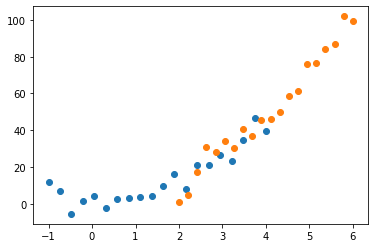

In [64]:
plt.scatter(x, y)
plt.scatter(x_new, y_new);

Ahora, debemos repetir con los datos nuevos el mismo proceso de generación de *features* o *feature engineering* que hicimos para los datos de entrenamiento. En nuestro caso, esto consiste en generar las mismas potencias de $x$. Probaremos el modelo de orden 10, ya que fue el que mejor pudo ajustarse a los datos de entrenamiento.

In [32]:
df_new = pd.DataFrame({'x':x_new, 'y':y_new})
df_new.head()

,x,y
0,2.000000,1.111359
1,2.210526,4.731892
2,2.421053,17.493786
3,2.631579,31.068881
4,2.842105,28.009038


In [33]:
for i in range(2,11):
    df_new['x{}'.format(i)] = df_new['x']**i
    
df_new = df_new[['x'] + ['x{}'.format(i) for i in range(2,11)] + ['y']]
df_new.head()

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,2.000000,4.000000,8.000000,16.000000,32.000000,64.000000,128.000000,256.000000,512.000000,1024.000000,1.111359
1,2.210526,4.886427,10.801575,23.877165,52.781101,116.674013,257.910977,570.119001,1260.263055,2785.844648,4.731892
2,2.421053,5.861496,14.190990,34.357134,83.180429,201.384195,487.561736,1180.412625,2857.841092,6918.983697,17.493786
3,2.631579,6.925208,18.224231,47.958502,126.206585,332.122593,874.006824,2300.017959,6052.678839,15928.102208,31.068881
4,2.842105,8.077562,22.957282,65.247013,185.438879,527.036815,1497.894107,4257.172724,12099.333006,34387.578017,28.009038


Ya tenemos los datos listos para que el modelo los pueda utilizar. Hagamos las predicciones:

In [34]:
y_pred_new = lr10.predict(df_new.drop(columns=['y']))

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿Qué hubiera pasado si no generábamos las potencias e intentábamos predecir sólo con $x$?</b></label></div>
</div>

Evaluemos el desempeño del modelo sobre los datos nuevos:

In [35]:
mae_new = mean_absolute_error(y_new, y_pred_new)
mse_new = mean_squared_error(y_new, y_pred_new)
rmse_new = np.sqrt(mse)
r2_new = r2_score(y_new, y_pred_new)

print('La media del error absoluto es', mae_new.round(2))
print('La media del error cuadrático es', mse_new.round(2))
print('La raíz del error cuadrático medio', rmse_new.round(2))
print('El R2 es', r2_new.round(2))

La media del error absoluto es 25447.93
La media del error cuadrático es 3979581203.69
La raíz del error cuadrático medio 7.51
El R2 es -4812617.28


Hmmm... ¿Qué pasó? **Pasamos de un $R^2$ de 0.96 a uno negativo con el modelo de grado 10**. Teniendo en cuenta que siempre buscamos obtener un $R^2$ lo más cercano a 1 posible, **un $R^2$ negativo nos da la pauta de que el modelo está prediciendo considerablemente mal estos datos nuevos**.

Analicemos qué está pasando e identifiquemos el problema. Grafiquemos las curvas de los distintos modelos y veamos cómo se aproxima cada una de ellas a los datos nuevos.

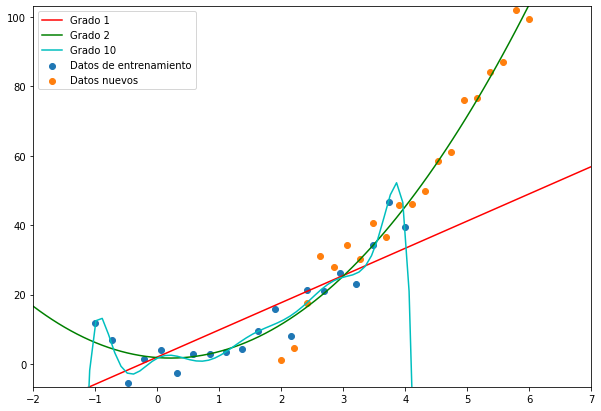

In [36]:
ejex = np.linspace(-2,8, 100)
plt.figure(figsize=(10,7))

# Ploteamos los datos
plt.scatter(x, y)
plt.scatter(x_new, y_new)

# Modelo de grado 1
curva1 = lr.predict(ejex.reshape(-1,1))
plt.plot(ejex, curva1, 'r')

# Modelo de grado 1
curva2 = lr2.predict(np.vander(ejex, 3, increasing=True)[:,1:])
plt.plot(ejex, curva2, 'g')

# Modelo de grado 10
curva10 = lr10.predict(np.vander(ejex, 11, increasing=True)[:,1:])

plt.plot(ejex, curva10, 'c')
plt.xlim([x.min()-1, x_new.max()+1])
plt.ylim([y.min()-1, y_new.max()+1])
plt.legend(['Grado 1', 'Grado 2', 'Grado 10', 'Datos de entrenamiento', 'Datos nuevos']);

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/haciendo_foco.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;"><label>El modelo de grado 1 busca ajustar una recta a datos que provienen de una función más bien cuadrática, por lo que no llega a captar la verdadera naturaleza de los datos. Por esto, decimos que el modelo es "demasiado simple", con una <i>performance</i> relativamente mala tanto en el set de entrenamiento como sobre los datos nuevos. Esto es lo que se conoce como <i><b>underfitting</b></i> o <b>subajuste</b>.
<br><br>
El modelo de grado 10, en cambio, es "demasiado complejo" y logra ajustarse casi a la perfección a este set de datos en particular, por lo que pierde capacidad de generalización y, al encontrarse con datos nuevos, tiene una <i>performance</i> mala y las métricas empeoran. Esto es lo que se conoce como <i><b>overfitting</b></i> o <b>sobreajuste</b>.
<br><br>
Por su parte, el modelo de grado 2 parecería ser el que mejor representa la estructura intrínseca de los datos, teniendo la suficiente flexibilidad como para ajustarse correctamente al set de entrenamiento y al mismo tiempo generalizar adecuadamente a datos nuevos.</label></div>
</div>

**¿Cómo podemos identificar cuál es la complejidad correcta de un modelo para nuestro problema?**

<a id='ttcv'></a>
## Train-test split y cross-validation

**La metodología que se utiliza para comparar diferentes modelos y evaluar cuál de ellos se desempeña mejor consiste en reservar una porción de los datos para conocer la capacidad de generalización de los distintos modelos**. Esto responde a la división de los datos en un *training set* y un *testing set* que ya hemos presentado en la notebook de introducción a *machine learning*.

Si entrenamos el modelo con un set de datos y luego lo evaluamos con datos distintos, podemos asumir que éste será el desempeño de predicción sobre datos provenientes de la misma distribución, por más que no hayan sido incluidos en el set de entrenamiento.

Vamos a reutilizar todos los datos que generamos hasta aquí y aplicar esta metodología para encontrar el grado óptimo del modelo para que se ajuste de la manera correcta, es decir, **evitando tanto el subajuste como el sobreajuste**.

In [37]:
# Concatenamos las tablas con los distintos datos generados
data = pd.concat([df, df_new], axis=0).reset_index(drop=True)
data.tail()

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
35,5.157895,26.603878,137.220003,707.766331,3650.584233,18829.329200,97119.697980,5.009332e+05,2.583761e+06,1.332677e+07,76.628806
36,5.368421,28.819945,154.717597,830.589207,4458.952583,23937.534920,128506.766411,6.898784e+05,3.703558e+06,1.988226e+07,84.092463
37,5.578947,31.124654,173.642805,968.744070,5404.572182,30151.823754,168215.437785,9.384651e+05,5.235647e+06,2.920940e+07,87.106852
38,5.789474,33.518006,194.051611,1123.456695,6504.222973,37656.027740,218008.581654,1.262155e+06,7.307213e+06,4.230492e+07,102.046904
39,6.000000,36.000000,216.000000,1296.000000,7776.000000,46656.000000,279936.000000,1.679616e+06,1.007770e+07,6.046618e+07,99.340152


In [38]:
# Importamos la función de Scikit-Learn para hacer el split
from sklearn.model_selection import train_test_split

Esta función retornará 4 sets diferentes (2 pares):
- $X$ de entrenamiento
- $y$ de entrenamiento
- $X$ de testeo
- $y$ de testeo

Usaremos $X$ e $y$ de entrenamiento para ajustar distintos modelos (`.fit(X_train, y_train)`) y luego usaremos $X$ de testeo para hacer nuevas predicciones (`.predict(X_test)`). Vamos a utilizar la métrica del $R^2$ para evaluar la *performance* de cada modelo, tanto sobre *train* como sobre *test*.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['y']), df['y'], random_state=22)

In [40]:
X_train.shape

(15, 10)

In [41]:
y_train.shape

(15,)

In [42]:
X_test.shape

(5, 10)

In [43]:
y_test.shape

(5,)

<a id='ttcv_comparando'></a>
### Comparando el ajuste y la generalización de distintos modelos

Con los datos ya separados, procedemos a entrenar los distintos modelos sólo con los datos de entrenamiento y analizar cómo se desempeñan en cada uno de los conjuntos, el de entrenamiento y el de testeo. Comparando estos valores podremos conocer el nivel de ajuste y la capacidad de generalización de cada uno de ellos.

<a id='ttcv_uno'></a>
#### Modelo de grado 1

Nuestro primer modelo es una regresión lineal simple, cuya única *feature* es $x$ (grado 1 del polinomio).

Ajustamos el modelo:

In [44]:
# Utilizamos sólo x para entrenar
lr = LinearRegression()
lr.fit(X_train[['x']], y_train);

Con el modelo ajustado, podemos hacer predicciones:

In [45]:
y_pred_train = lr.predict(X_train[['x']])
y_pred_test = lr.predict(X_test[['x']])

Y calular métricas:

In [46]:
print('El R2 de entrenamiento del modelo de grado 1 es', r2_score(y_train, y_pred_train).round(2))
print('El R2 de testeo del modelo de grado 1 es', r2_score(y_test, y_pred_test).round(2))

El R2 de entrenamiento del modelo de grado 1 es 0.71
El R2 de testeo del modelo de grado 1 es 0.69


El modelo simple presenta un $R^2$ relativamente bajo tanto en *train* como en *test*. **Éste suele ser un claro signo de sesgo o subajuste**.

<a id='ttcv_dos'></a>
#### Modelo de grado 2

Nuestro segundo modelo es una regresión lineal múltiple, que incorpora $x^2$ como variable explicativa (grado 2 del polinomio).

Ajustamos el modelo:

In [47]:
# Utilizamos x y x al cuadrado para entrenar
lr2 = LinearRegression()
lr2.fit(X_train[['x', 'x2']], y_train);

Predecimos:

In [48]:
y_pred_train_2 = lr2.predict(X_train[['x', 'x2']])
y_pred_test_2 = lr2.predict(X_test[['x', 'x2']])

Y evaluamos:

In [49]:
print('El R2 de entrenamiento del modelo de grado 2 es', r2_score(y_train, y_pred_train_2).round(2))
print('El R2 de testeo del modelo de grado 2 es', r2_score(y_test, y_pred_test_2).round(2))

El R2 de entrenamiento del modelo de grado 2 es 0.9
El R2 de testeo del modelo de grado 2 es 0.98


Usando un modelo cuadrático, mejoraron considerablemente ambas métricas. ¡Este modelo, incluso, predice mejor los datos desconocidos que los que se usaron para entrenarlo!

<a id='ttcv_diez'></a>
#### Modelo de grado 10

Nuestro tercer modelo explorado es otra regresión lineal múltiple, que incorpora 10 grados del polinomio como *features*.

Ajustamos el modelo:

In [50]:
# Utilizamos todas las variables para entrenar
lr10 = LinearRegression()
lr10.fit(X_train, y_train);

Predecimos:

In [51]:
y_pred_train_10 = lr10.predict(X_train)
y_pred_test_10 = lr10.predict(X_test)

Y evaluamos:

In [52]:
print('El R2 de entrenamiento del modelo de grado 10 es', r2_score(y_train, y_pred_train_10).round(2))
print('El R2 de testeo del modelo de grado 10 es', r2_score(y_test, y_pred_test_10).round(2))

El R2 de entrenamiento del modelo de grado 10 es 0.97
El R2 de testeo del modelo de grado 10 es 0.6


Este modelo ajusta casi a la perfección a los datos de entrenamiento pero tiene un pésimo desempeño cuando predice datos nuevos, incluso peor que aquel propio del modelo simple. **Una buena métrica de entrenamiento y una mala métrica de testeo es un síntoma claro de varianza o sobreajuste**.

De este análisis surge la duda de **cuál es la complejidad óptima del modelo**, el mejor balance entre subajuste y sobreajuste. A continuación, entrenamos varios modelos incrementando en cada iteración su nivel de complejidad y evaluamos la *performance* sobre *train* y *test*:

In [53]:
train_scores = []
test_scores = []

for i in range(X_train.shape[1]):
    lr.fit(X_train.iloc[:,:i+1], y_train)
    y_pred_train = lr.predict(X_train.iloc[:,:i+1])
    y_pred_test = lr.predict(X_test.iloc[:,:i+1])
    train_scores.append(r2_score(y_train, y_pred_train))
    test_scores.append(r2_score(y_test, y_pred_test))

Representemos cómo varía el $R^2$ en el set de entrenamiento y en el set de testeo en función de la complejidad del modelo:

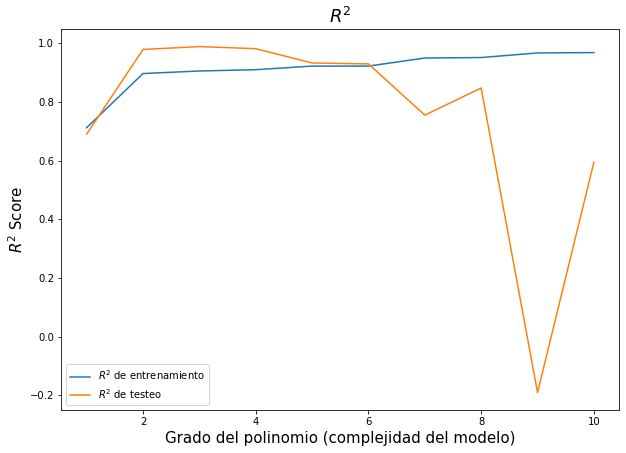

In [54]:
plt.figure(figsize=(10,7))
plt.plot(list(range(1,X_train.shape[1]+1)),train_scores)
plt.plot(list(range(1,X_train.shape[1]+1)),test_scores)
plt.legend([f'$R^2$ de entrenamiento', '$R^2$ de testeo'])
plt.title('$R^2$',fontdict=dict(fontsize=18))
plt.xlabel('Grado del polinomio (complejidad del modelo)', fontdict=dict(fontsize=15))
plt.ylabel(f'$R^2$ Score', fontdict=dict(fontsize=15));

Vemos que **al aumentar la complejidad del modelo, el *score* de entrenamiento (representado por la línea azul) siempre mejora**. Esto significa que modelos más complejos tienen **mayor capacidad de ajustarse a los datos de entrenamiento**.

Sin embargo, lo que más nos interesa es evaluar qué ocurre cuando predecimos datos nuevos, y por eso **resulta más importante analizar el comportamiento de la curva de *score* de testeo (línea naranja)**. En este caso, observamos que al inicio el $R^2$ de *test* mejora al incrementar el grado del polinomio, pero **a partir del grado 6, la capacidad de generalización cae y la brecha con respecto al *score* de entrenamiento se agranda considerablemente**.

In [55]:
# El mejor score de testeo es...
max(test_scores).round(2)

0.99

In [56]:
# ... y ocurre para el grado...
test_scores.index(max(test_scores)) + 1

3

<div id="caja10" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <br>
  <div style="float:left;width: 85%;"><label><b>¿No es llamativo que el mejor <i>score</i> se dé en grado 3 cuando nuestros datos fueron generados por una función de grado 2?<br> Estos resultados, ¿no estarán afectados por la aleatoriedad propia del proceso del <i>train-test split</i>?<br> ¿Cómo podemos darle mayor robustez a este análisis?</b></label></div>
</div>

<a id='ttcv_cv'></a>
### Cross-validation

El procedimiento que acabamos de realizar dividiendo el dataset entre un set de entrenamiento y otro de testeo es un caso particular del método de validación cruzada o *cross-validation* en inglés. Cuando hacemos validación cruzada, **armamos múltiples sets de entrenamiento y validación a partir de un mismo conjunto de datos de entrenamiento**, de forma tal de poder realizar varias pruebas sobre distintos datos desconocidos por el modelo y así tener una mejor noción acerca de su capacidad de generalización.

<img src="img/3-fold-CV.png" align="center"/>
<div class='epigraph' align="center"><i>3-fold cross validation</i></div><br>

**Este esquema ilustra una estrategia de *cross validation* con 3 particiones o *folds*. Tomamos el dataset de entrenamiento y lo dividimos en tres partes de igual tamaño. En cada prueba, entrenamos con 2/3 de los datos y validamos con las observaciones restantes. Lo importante es que, prueba a prueba, los datos de entrenamiento no son siempre idénticos y los datos de validación nunca se repiten, de ahí la idea de "validación cruzada".**

Realizando múltiples *folds* le damos más robustez estadística al análisis ya que promediamos varios resultados con distintos sets de entrenamiento y validación. En general, trabajamos con 3, 5 o 10 *folds* de validación cruzada.

La función `cross_val_score()` de Scikit-Learn nos permite implementar este método sin tener que programarlo a mano. Veamos cómo funciona:

```
sklearn.model_selection.cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=’warn’, n_jobs=None, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’)
```

Concentrémonos en los argumentos `estimator`, `X`, `y` y `cv`:
- `estimator` recibe el estimador que vamos a entrenar. En otras palabras, el objeto que contiene el modelo.
- `X` e `y` son los datos que usaremos para el entrenamiento (X_train e y_train).
- `cv` es la cantidad de *folds* que queremos realizar.

Ejecutemos la función con estos parámetros y veamos qué sucede

In [57]:
# Importamos la función cross_val_score del módulo de selección de modelos
from sklearn.model_selection import cross_val_score

# La ejecutamos indicando como estimador una regresión lineal, especificando el set de train y cuántos folds queremos
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=3)

array([-6.68552738e+00, -8.68434122e+05, -6.19305616e+02])

El resultado del método es un array que contiene tantos elementos como *folds* hayamos elegido para trabajar. **Cada valor indica el *score* que se obtuvo sobre el set de validación de una prueba en particular**. Como se trata de un problema de regresión, el *score* por defecto es el $R^2$, pero podemos elegir otras métricas variando el argumento `scoring` de la función.

Sobre estos resultados, **podemos calcular un *score* promedio de validación cruzada**, el cual nos dará una idea más clara acerca de cómo performa un modelo de una cierta complejidad sobre distintos datos nuevos:

In [58]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=3).mean()

-289686.7043474522

También, podemos calcular alguna medida de dispersión, como el desvío estándar:

In [59]:
cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=3).std()

409236.2999686011

Repitamos ahora el ejercicio anterior de iterar sobre los distintos grados posibles del polinomio, esta vez haciendo validación cruzada y calculando la media de los *scores* obtenidos:

In [60]:
cv_scores_mean = []

for i in range(X_train.shape[1]):
    estimator = LinearRegression()
    cv_score = cross_val_score(estimator, X_train.iloc[:, :i+1], y_train, cv=3)
    cv_scores_mean.append(cv_score.mean())

In [61]:
# El mejor score promedio de validación cruzada es...
max(cv_scores_mean).round(2)

0.59

In [62]:
# ... y ocurre para el grado...
cv_scores_mean.index(max(cv_scores_mean)) + 1

2

Luego de realizar múltiples pruebas siguiendo la estrategia de validación cruzada, **identificamos que el modelo que mejores resultados obtiene en promedio es aquel de grado 2**, tal como era de esperar considerando la naturaleza de los datos con los que estamos trabajando.

**Siempre que deseemos identificar cuál el el grado de complejidad o la configuración óptima de un modelo, será importante realizar diversas pruebas de *cross validation* para contar con resultados robustos que nos ayuden a seleccionar el mejor modelo.**

<a class="anchor" id="section_resumen"></a>
## En resumen

En esta notebook, introdujimos algunos de los conceptos esenciales de *machine learning*: **sesgo y varianza, *underfitting* y *overfitting* y *cross-validation***.
<br>

<div id="caja9" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/kit_de_salida.png"/> </div>
  <div style="float:left;width: 85%;"><label><b> - Modelos muy simples subajustan a los datos, es decir, no tienen la capacidad de aprender correctamente la relación entre las <i>features</i> y el <i>target</i>. Esto hace que tengan alto sesgo y resultados relativamente malos, tanto en el set de entrenamiento como en el de testeo.<br><br>
                                                 - Por su parte, modelos muy complejos tienen una excesiva flexibilidad, la cual les permite aprender con sumo detalle la relación entre las <i>features</i> y el <i>target</i> al sobreajustar a los datos. Como contracara, estos modelos tienen alta varianza, que se evidencia cuando se contrastan muy buenos resultados en el set de entrenamiento con muy bajos rendimientos en el de testeo.<br><br>
                                                 - <i>Cross-validation</i> es una estrategia que consiste en iterar sobre múltiples sets de entrenamiento y validación a partir de un mismo conjunto de datos de entrenamiento, de forma tal de poder realizar varias pruebas sobre distintos datos desconocidos por el modelo y así tener una mejor noción acerca de su capacidad media de generalización. Las pruebas de validación cruzada dotan de mayor robustez estadística a la evaluación de modelos y serán un paso importante de nuestros análisis siempre que deseemos seleccionar aquel modelo que mejor <i>performance</i> tiene.
      </b></label></div>